In [ ]:
# Automation of manual single cell tasks done in previous notebook 

In [2]:
from pathlib import Path
import re, warnings, os
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
import torch
import seaborn as sns
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt
import squidpy as sq

/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
ribo_genes = pd.read_table("rib.txt", skiprows=2, header=None)   

def save_figure(obj, name: str, plot_dir: str | Path | None):
    """Save Scanpy/Matplotlib output returned by sc.pl.* or seaborn."""
    if plot_dir is None:
        return
    plot_dir = Path(plot_dir)
    plot_dir.mkdir(parents=True, exist_ok=True)

    if isinstance(obj, sns.axisgrid.FacetGrid):
        fig = obj.fig
    elif isinstance(obj, list):  # list of Axes
        fig = obj[0].figure
    elif hasattr(obj, "savefig"):  # Figure
        fig = obj
    else:  # single Axes
        fig = obj.figure

    fig.savefig(plot_dir / f"{name}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

import re

def get_patient_tag(s: str | None) -> str:
    """Convert raw sample string (…P2CRC, …P5NAT) to P2CRC, P5NAT"""
    if s is None:
        return "unknown"
    m = re.search(r"_P(\d+)(CRC|NAT)", s)
    return f"P{m.group(1)}{m.group(2)}" if m else "unknown"


def processing_data(
        h5_path: str,
        patient_tag: str,
        outfile: Path,
        mito_pct_max: float = 20,
        ribo_pct_max: float = 2,
        gene_quantile: float = 0.98,
        number_hvg: int = 2000,
        agg_csv: Path = Path("HumanColonCancer_Flex_Multiplex_aggregation.csv"),
        *,
        make_plots: bool = True,
        plot_dir: Path,
    ) -> sc.AnnData:

    """
    The way this script works set parameters in process data function, 
    then load, QC metrics, doublet filter and process for single patient. 

    look at QC stats and plots too. 

    Parameters:
    h5_path: path to filtured feature matrix
    patient_tag: label stored in adata.obs['patient']
    barcode_regex: regex for matching with patient’s barcodes
    mito_pct_max: mito-reads cutoff  (percent)
    ribo_pct_max: ribo-reads cutoff 
    gene_quantile: upper nGene quantile to keep (we use .98)
    number_hvg: number of HVGs to select
    agg_csv: aggregation.csv to map barcode suffix to sample id
    outfile: output h5 file
    make_plots: turn plotting on/off
    plot_dir: directory where PNGs are saved 
    """
    adata = sc.read_10x_h5(h5_path)
    adata.var_names_make_unique()
    adata.obs["patient"] = patient_tag
    
    #filter out genes since in less than 10 cells
    sc.pp.filter_genes(adata, min_cells=10)

    if Path(agg_csv).exists():
        df = pd.read_csv(agg_csv)
        df.columns = df.columns.str.strip().str.lower()
        suffix_map = {str(i + 1): sid for i, sid in enumerate(df["sample_id"])}
        adata.obs["suffix"] = adata.obs_names.str.split("-").str[-1]
        adata.obs["sample_id"] = adata.obs["suffix"].map(suffix_map)
        adata.obs["patient_tag"] = (
            adata.obs["sample_id"].fillna("").astype(str).apply(get_patient_tag)
        )
        adata = adata[adata.obs["patient_tag"] == patient_tag].copy() 

        
    #Doublet filtering (SOLO)
   
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()

    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()

    soft = solo.predict()
    soft["prediction"] = solo.predict(soft=False)
    soft["diff"] = soft.doublet - soft.singlet
    doublets = soft.index[soft.prediction == "doublet"]
    adata.obs["doublet"] = adata.obs.index.isin(doublets)
    adata = adata[~adata.obs.doublet].copy()

    adata.var["mt"]   = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo"],
                               percent_top=None, log1p=False, inplace=True)
    
    sc.pp.filter_genes(adata,min_cells =3)
    #sc.pp.filter_cells(p5_adata, min_genes=200)

    upper_lim = np.quantile(adata.obs.n_genes_by_counts, gene_quantile)
    adata = adata[
        (adata.obs.n_genes_by_counts < upper_lim) &
        (adata.obs.pct_counts_mt   < mito_pct_max) &
        (adata.obs.pct_counts_ribo < ribo_pct_max)
    ].copy()

    if make_plots:
        fig = sc.pl.violin(
            adata,
            ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
            jitter=0.4, multi_panel=True, show=False)
        save_figure(fig, f"{patient_tag}_QC_violin", plot_dir)


    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata

    sc.pp.highly_variable_genes(
        adata, n_top_genes=number_hvg, flavor="seurat_v3"
    )
    if make_plots:
        fig = sc.pl.highly_variable_genes(adata, show=False)
        save_figure(fig, f"{patient_tag}_HVGs", plot_dir)

    adata = adata[:, adata.var.highly_variable].copy()


    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt", "pct_counts_ribo"])
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")

    if make_plots:
        sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50, show=False)
        fig = plt.gcf()
        save_figure(fig, f"{patient_tag}_PCA_var_ratio", plot_dir)



    sc.pp.neighbors(adata, n_pcs=30)
    sc.tl.umap(adata)
    if make_plots:
        fig = sc.pl.umap(adata, show=False)
        save_figure(fig, f"{patient_tag}_UMAP_preLeiden", plot_dir)

    sc.tl.leiden(adata, resolution=0.5, key_added="leiden_local")
    if make_plots:
        fig = sc.pl.umap(adata, color="leiden_local", show=False)
        save_figure(fig, f"{patient_tag}_UMAP_leiden", plot_dir)

    
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("Device name:", torch.cuda.get_device_name(0))

    if outfile:
        adata.write_h5ad(outfile, compression="gzip")
    return adata


In [3]:
p2 = processing_data(
        h5_path="HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5",
        patient_tag="P2CRC",
        outfile="P2CRC_clean.h5ad",
        make_plots=True,
        plot_dir="plots")

p5 = processing_data(
        h5_path="HumanColonCancer_Flex_Multiplex_count_filtered_feature_bc_matrix.h5",
        patient_tag="P5CRC",
        outfile="P5CRC_clean.h5ad",
        make_plots=True,
        plot_dir="plots")


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system bu

Epoch 191/191: 100%|█| 191/191 [06:37<00:00,  2.06s/it, v_num=1, train_lo

`Trainer.fit` stopped: `max_epochs=191` reached.


Epoch 191/191: 100%|█| 191/191 [06:37<00:00,  2.08s/it, v_num=1, train_lo
INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/jjoseph/.local/lib/python3.10/site-package ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: 

Epoch 312/400:  78%|▊| 312/400 [09:19<02:37,  1.79s/it, v_num=1, train_lo
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.355. Signaling Trainer to stop.


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: U

CUDA available: True
Device name: NVIDIA L40S


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system bu

Epoch 325/325: 100%|█| 325/325 [09:03<00:00,  2.32s/it, v_num=1, train_lo

`Trainer.fit` stopped: `max_epochs=325` reached.


Epoch 325/325: 100%|█| 325/325 [09:03<00:00,  1.67s/it, v_num=1, train_lo
INFO     Creating doublets, preparing SOLO model.                                                                  


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/jjoseph/.local/lib/python3.10/site-package ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: 

Epoch 386/400:  96%|▉| 386/400 [07:51<00:17,  1.22s/it, v_num=1, train_lo
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.279. Signaling Trainer to stop.


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/legacy_api_wrap/__init__.py:82: U

CUDA available: True
Device name: NVIDIA L40S


In [5]:
import pandas as pd
df = pd.read_csv("HumanColonCancer_Flex_Multiplex_aggregation.csv")
df.columns = df.columns.str.strip().str.lower()
for i, sid in enumerate(df["sample_id"], start=1):
    print(f"suffix {i}  →  {sid}")


suffix 1  →  20k_HumanColonCancer_Flex_Multiplex_P1L1_P2CRC_BC1
suffix 2  →  20k_HumanColonCancer_Flex_Multiplex_P1L1_P4CRC_BC2
suffix 3  →  20k_HumanColonCancer_Flex_Multiplex_P1L2_P2CRC_BC1
suffix 4  →  20k_HumanColonCancer_Flex_Multiplex_P1L2_P4CRC_BC2
suffix 5  →  20k_HumanColonCancer_Flex_Multiplex_P1L3_P2CRC_BC1
suffix 6  →  20k_HumanColonCancer_Flex_Multiplex_P1L3_P4CRC_BC2
suffix 7  →  20k_HumanColonCancer_Flex_Multiplex_P1L4_P2CRC_BC1
suffix 8  →  20k_HumanColonCancer_Flex_Multiplex_P1L4_P4CRC_BC2
suffix 9  →  40k_HumanColonCancer_Flex_Multiplex_P2L1_P1CRC_BC1
suffix 10  →  40k_HumanColonCancer_Flex_Multiplex_P2L1_P3CRC_BC2
suffix 11  →  40k_HumanColonCancer_Flex_Multiplex_P2L1_P5CRC_BC3
suffix 12  →  40k_HumanColonCancer_Flex_Multiplex_P2L1_P2NAT_BC4
suffix 13  →  40k_HumanColonCancer_Flex_Multiplex_P2L2_P1CRC_BC1
suffix 14  →  40k_HumanColonCancer_Flex_Multiplex_P2L2_P3CRC_BC2
suffix 15  →  40k_HumanColonCancer_Flex_Multiplex_P2L2_P5CRC_BC3
suffix 16  →  40k_HumanColonCancer

In [ ]:
# Integration Plots for P2 CRC and P5 CRC

patient
P2CRC    27855
P5CRC    18592
Name: count, dtype: int64


Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/home/jjoseph/.local/lib/python3.10/site-package ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: 

Epoch 172/172: 100%|███| 172/172 [08:03<00:00,  3.84s/it, v_num=1, train_loss_step=226, train_loss_epoch=214]

`Trainer.fit` stopped: `max_epochs=172` reached.


Epoch 172/172: 100%|███| 172/172 [08:03<00:00,  2.81s/it, v_num=1, train_loss_step=226, train_loss_epoch=214]


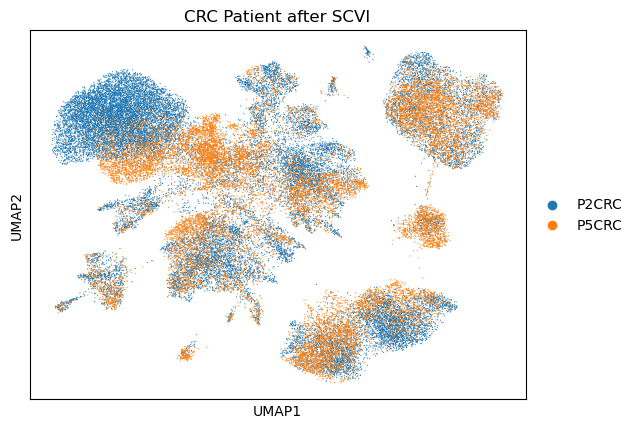

/scratch/ipykernel_18485/34207037.py:50: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_joint", resolution=0.5)


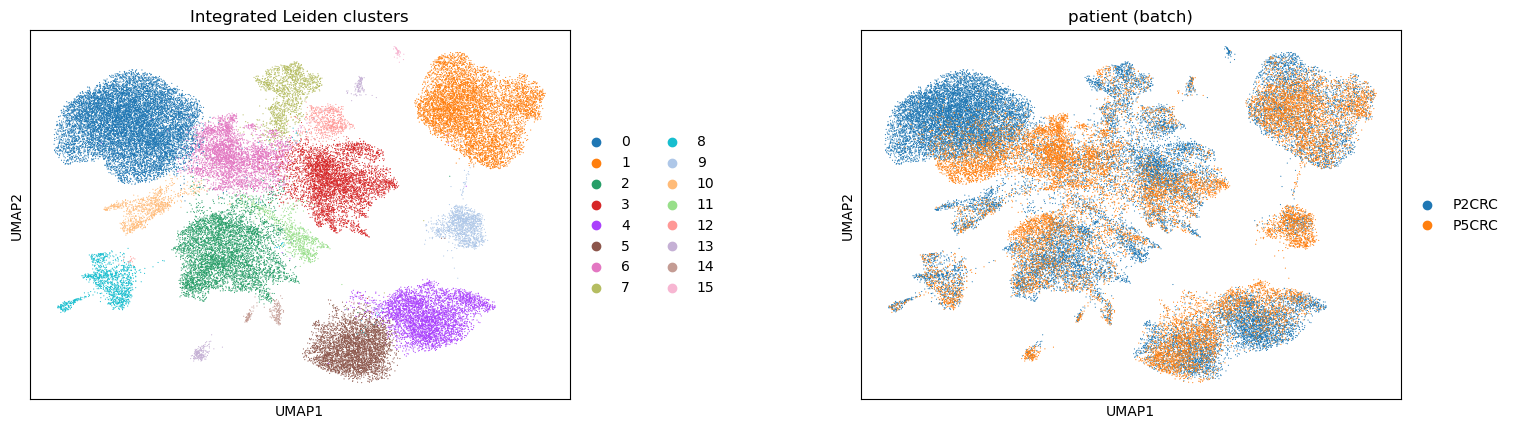

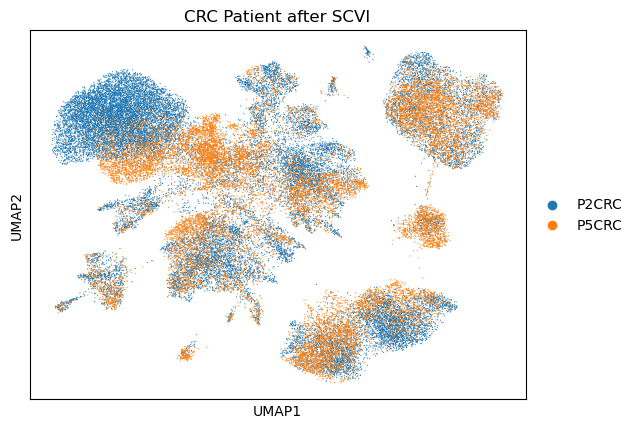

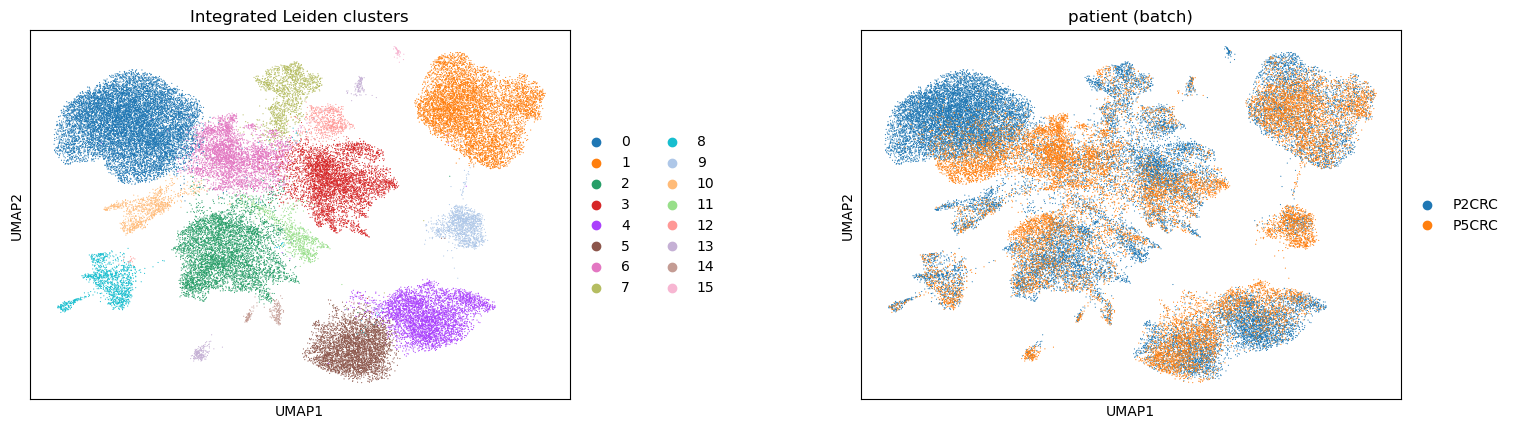

In [3]:
import scanpy as sc
import scvi
from pathlib import Path

#concatenate the data and add a column for patient for both 

p2 = sc.read_h5ad("P2CRC_clean.h5ad")
p5 = sc.read_h5ad("P5CRC_clean.h5ad")


# Need to fix, re run with inner (we just want intersection of genes)
adata = sc.concat(
    {"P2CRC": p2, "P5CRC": p5},  
    label="patient",              
    join="outer", fill_value=0    # union of genes
)

print(adata.obs["patient"].value_counts())


#scvi integration 

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    flavor="seurat_v3",
    batch_key="patient",
    layer="counts"    # use raw counts not normalized scvi uses it
)
adata = adata[:, adata.var.highly_variable]
adata = adata[:, adata.var.highly_variable].copy() 

scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",           
    batch_key="patient",    
    continuous_covariate_keys=[
        "pct_counts_mt", "total_counts", "pct_counts_ribo"
    ]
)

model = scvi.model.SCVI(adata)
model.train()

adata.obsm["X_scVI"] = model.get_latent_representation()

sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

sc.pl.umap(adata, color=["patient"], title="CRC Patient after SCVI")

sc.tl.leiden(adata, key_added="leiden_joint", resolution=0.5)

sc.pl.umap(
    adata,
    color=["leiden_joint", "patient"],
    wspace=0.4,
    title=["Integrated Leiden clusters", "patient (batch)"]
)


scRNA_int = adata        
scRNA_int.write_h5ad("integrated_P2_P5_scVI.h5ad", compression="gzip")

sc.pl.umap(
    adata,
    color=["patient"],
    title="CRC Patient after SCVI",
    save="_patient.png"  
)

sc.pl.umap(
    adata,
    color=["leiden_joint", "patient"],
    wspace=0.4,
    title=["Integrated Leiden clusters", "patient (batch)"],
    save="_leiden_patient.png"
)





In [1]:
# QC plot 
'''
This next block reads the single cell meta data and combines to ann data. It create df and makes three umpas, 
our joint leiden cluster, the level 1 cell types and level 2 cell types. 
'''

'\nThis next block reads the single cell meta data and combines to ann data. It create df and makes three umpas, \nour joint leiden cluster, the level 1 cell types and level 2 cell types. \n'

/scratch/ipykernel_4189640/193537484.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(adata.obs["patient"])


missing_patient  missing_qcfilter  missing_level1  missing_level2
patient                                                                   
P2CRC                  0                 0               0               0
P5CRC                  0                 0               0               0

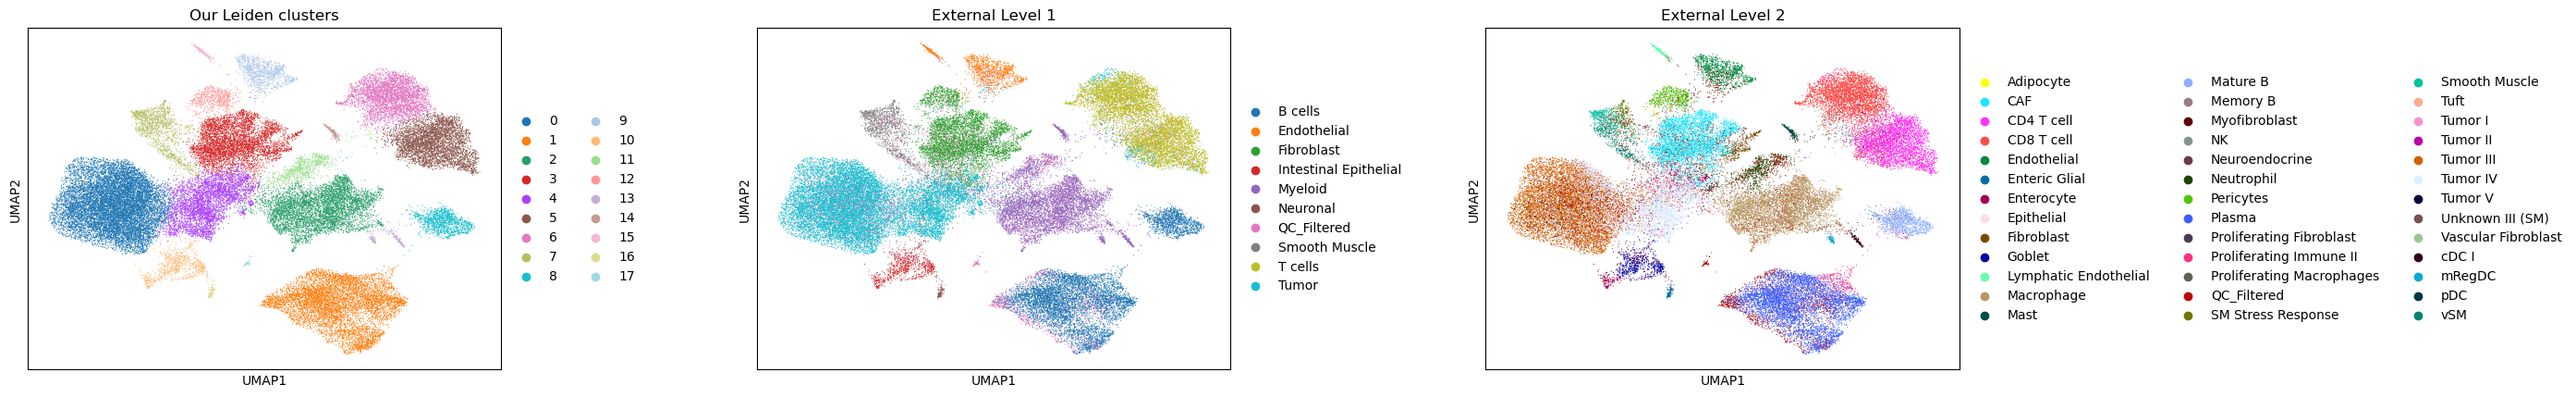

In [15]:
# load meta data

meta_path = Path("SingleCell_MetaData.csv")
meta = pd.read_csv(meta_path)
meta.columns = meta.columns.str.strip()


# align the names/barcodes with csv 
meta.index = meta["Barcode"]
meta = meta.reindex(adata.obs_names)

for col in ["QCFilter", "Level1", "Level2"]:
    adata.obs[col] = meta[col]


#check print statements 

# do number of rows match? 

summary = (
    adata.obs[["patient", "QCFilter", "Level1", "Level2"]]
    .isna()
    .groupby(adata.obs["patient"])
    .sum()
    .rename(columns=lambda x: f"missing_{x.lower()}")
)
display(summary)

sc.pl.umap(
    adata,
    color=["leiden_joint", "Level1", "Level2"],
    wspace=0.4,        # puts plots on one row
    na_color="lightgrey",
    title=["Our Leiden clusters", "External Level 1", "External Level 2"], 
    
)

for label in ["leiden_joint", "Level1", "Level2"]:
    sc.pl.umap(
        adata,
        color=label,
        na_color="lightgrey",
        size=15,
        save=f"_{label}_qc.png",  
        show=False
    )


In [ ]:
# Enact Data/Comparison

AnnData object with n_obs × n_vars = 319662 × 1089
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'
Index(['cell_type', 'patch_id'], dtype='object')
AnnData object with n_obs × n_vars = 294395 × 1089
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'
Index(['cell_type', 'patch_id'], dtype='object')


/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/gpfs/commons/groups/innovation/jjoseph/enact_results/integrate_env/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


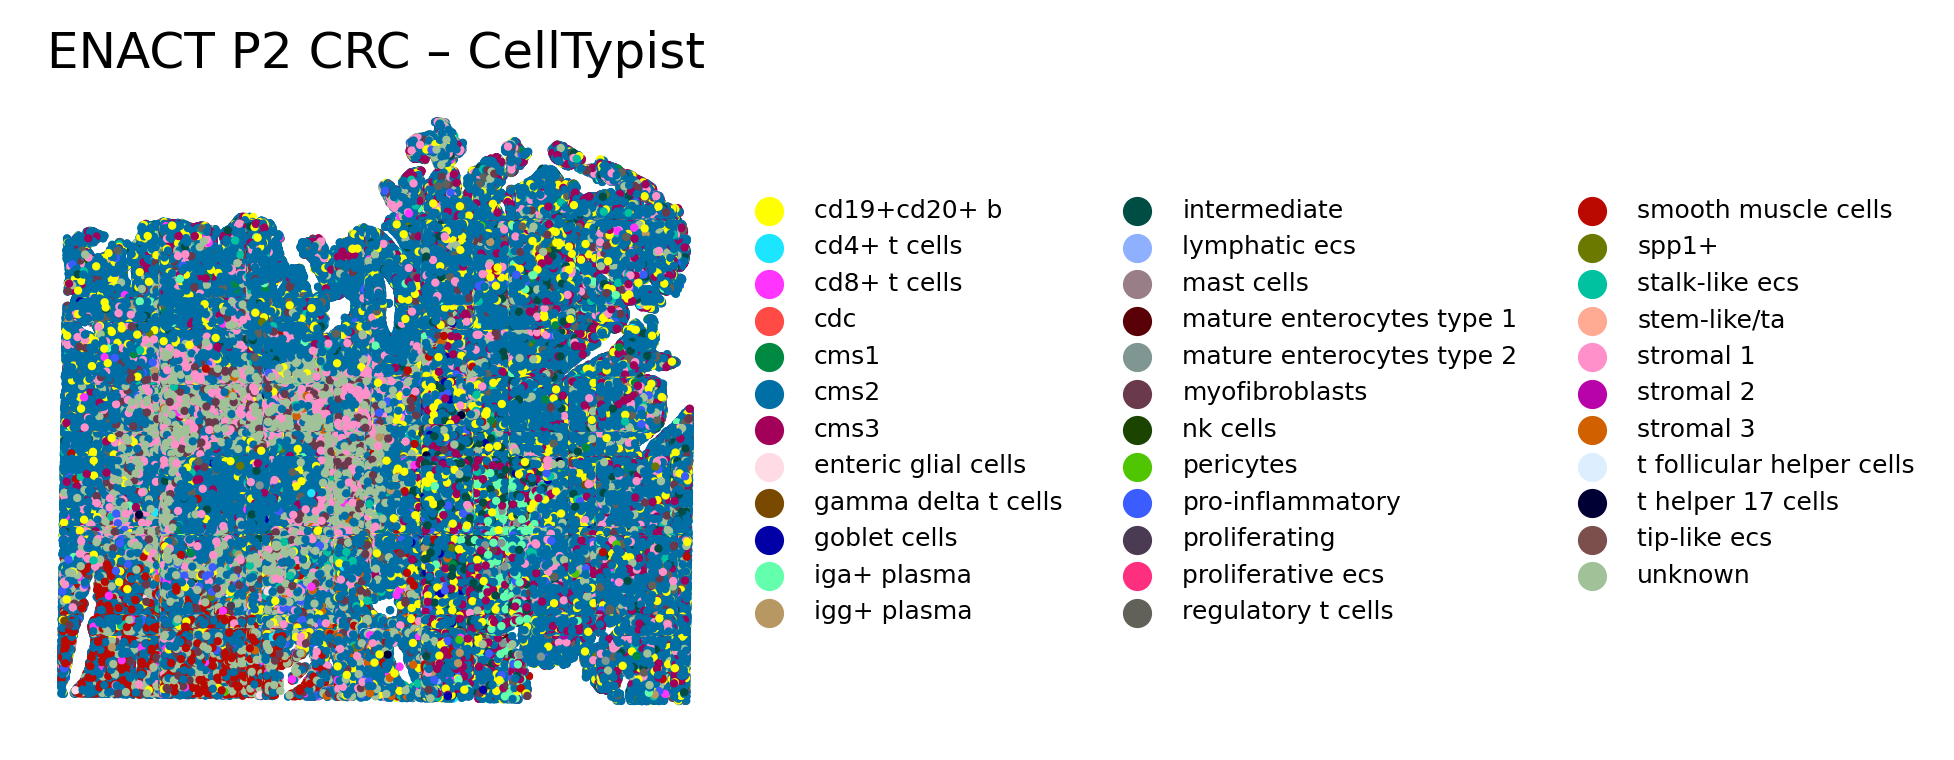

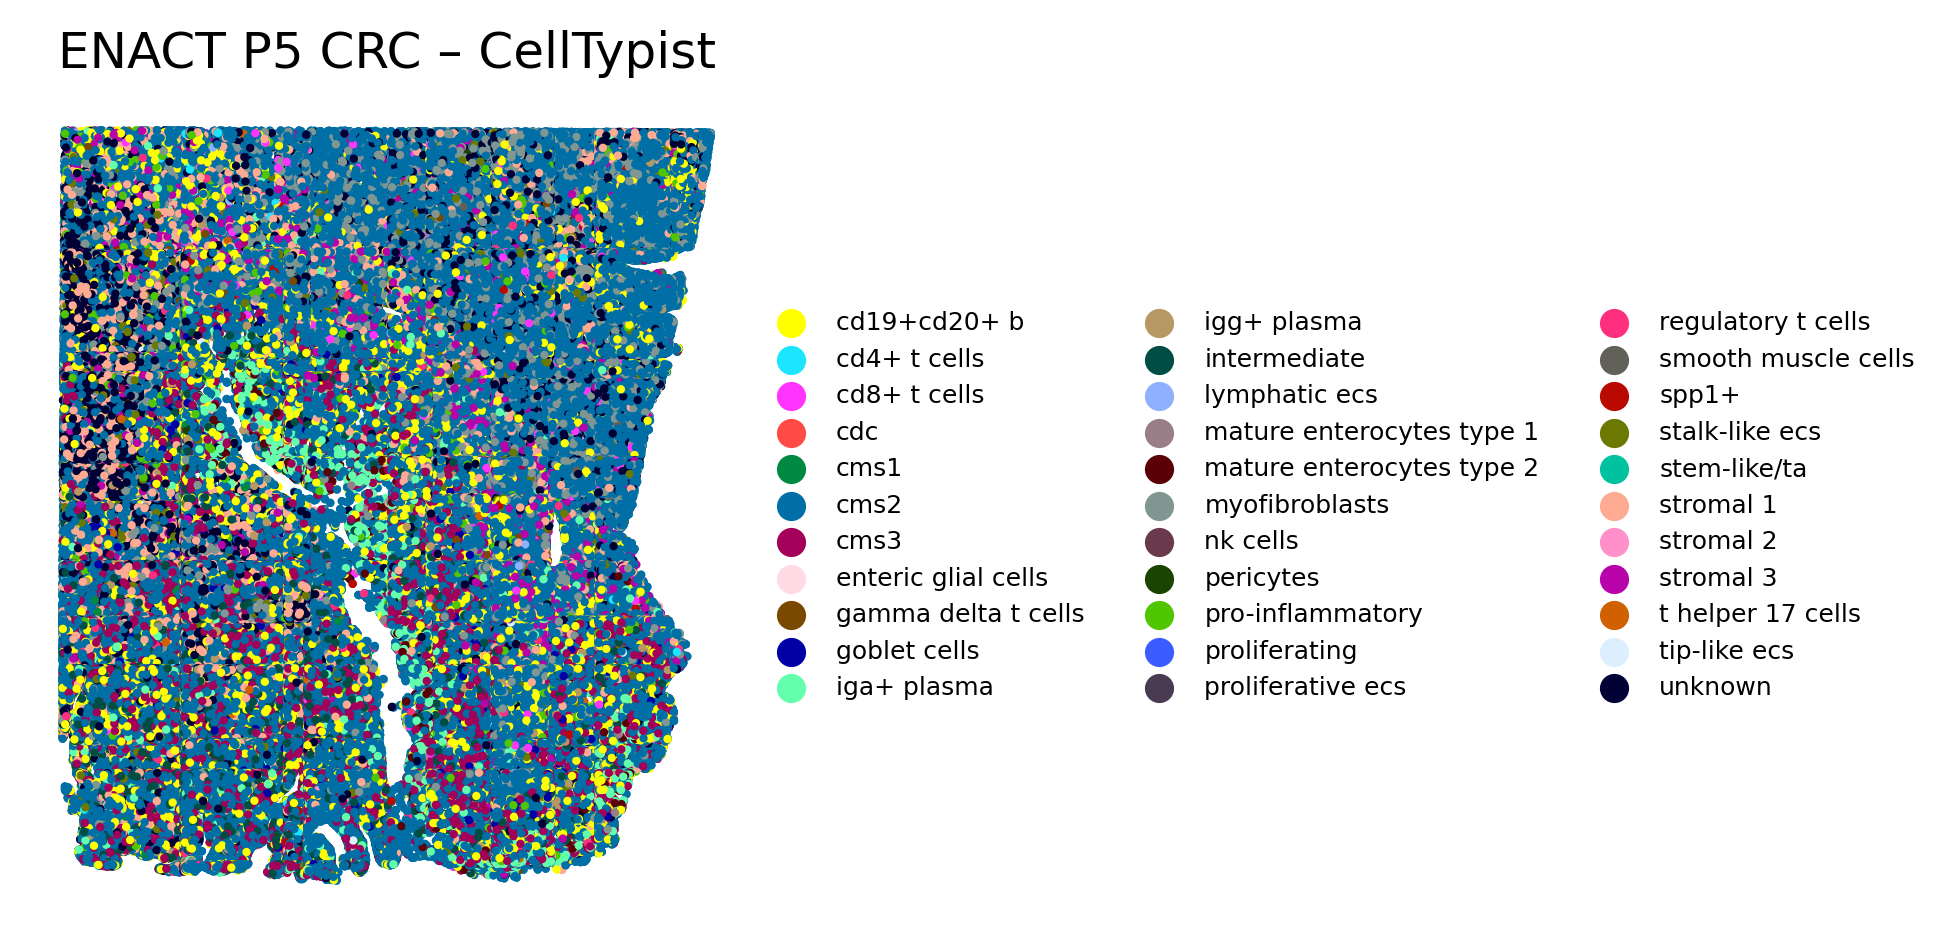

In [15]:
p2_sp = sc.read_h5ad('/gpfs/commons/groups/innovation/jjoseph/enact_results/P2_CRC/Cache/colon_P2/tmap/weighted_by_area|celltypist_cells_adata.h5')
print(p2_sp)
print(p2_sp.obs.columns)


p5_sp = sc.read_h5ad('/gpfs/commons/groups/innovation/jjoseph/enact_results/P5_CRC/Cache/colon_P5_demo/tmap/weighted_by_area|celltypist_cells_adata.h5')
print(p5_sp)
print(p5_sp.obs.columns)


import pandas as pd
import squidpy as sq

def ensure_numpy_spatial(adata):
    if isinstance(adata.obsm["spatial"], pd.DataFrame):
        adata.obsm["spatial"] = adata.obsm["spatial"].to_numpy(dtype="float32")

# ─── OPTIONAL: silence the “please specify library_id” warning ────────────
def add_dummy_library(adata, lib_id="dummy"):
    if "spatial" not in adata.uns:                      # only if absent
        adata.uns["spatial"] = {
            lib_id: {"images": {}, "scalefactors": {}, "metadata": {}}
        }
    adata.obs["library_id"] = lib_id

for ad, label in [(p2_sp, "ENACT P2 CRC – CellTypist"),
                  (p5_sp, "ENACT P5 CRC – CellTypist")]:
    ensure_numpy_spatial(ad)

    sq.pl.spatial_scatter(
        ad,
        color="cell_type",
        size=4,
        img=False,
        shape=None,
        frameon=False,
        title=label,
        legend_loc="right margin",   # keeps legend outside axes
        legend_fontsize=6,           # shrink text
        dpi=300
    )

